In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2016 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Natural Neighbor Verification

Walks through the steps of Natural Neighbor interpolation to validate that the algorithmic
approach taken in MetPy is correct.

Find natural neighbors visual test

A triangle is a natural neighbor for a point if the
[circumscribed circle](https://en.wikipedia.org/wiki/Circumscribed_circle) of the
triangle contains that point. It is important that we correctly grab the correct triangles
for each point before proceeding with the interpolation.

Algorithmically:

1. We place all of the grid points in a KDTree. These provide worst-case O(n) time
   complexity for spatial searches.

2. We generate a [Delaunay Triangulation](https://docs.scipy.org/doc/scipy/
   tutorial/spatial.html#delaunay-triangulations)
   using the locations of the provided observations.

3. For each triangle, we calculate its circumcenter and circumradius. Using
   KDTree, we then assign each grid a triangle that has a circumcenter within a
   circumradius of the grid's location.

4. The resulting dictionary uses the grid index as a key and a set of natural
   neighbor triangles in the form of triangle codes from the Delaunay triangulation.
   This dictionary is then iterated through to calculate interpolation values.

5. We then traverse the ordered natural neighbor edge vertices for a particular
   grid cell in groups of 3 (n - 1, n, n + 1), and perform calculations to generate
   proportional polygon areas.

   Circumcenter of (n - 1), n, grid_location
   Circumcenter of (n + 1), n, grid_location

   Determine what existing circumcenters (ie, Delaunay circumcenters) are associated
   with vertex n, and add those as polygon vertices. Calculate the area of this polygon.

6. Increment the current edges to be checked, i.e.:
   n - 1 = n, n = n + 1, n + 1 = n + 2

7. Repeat steps 5 & 6 until all the edge combinations of 3 have been visited.

8. Repeat steps 4 through 7 for each grid cell.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
from scipy.spatial.distance import euclidean

from metpy.interpolate import geometry
from metpy.interpolate.points import natural_neighbor_point

For a test case, we generate 10 random points and observations, where the
observation values are just the x coordinate value times the y coordinate
value divided by 1000.

We then create two test points (grid 0 & grid 1) at which we want to
estimate a value using natural neighbor interpolation.

The locations of these observations are then used to generate a Delaunay triangulation.

Text(62.0, 60.0, 'grid 1: 3.746')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


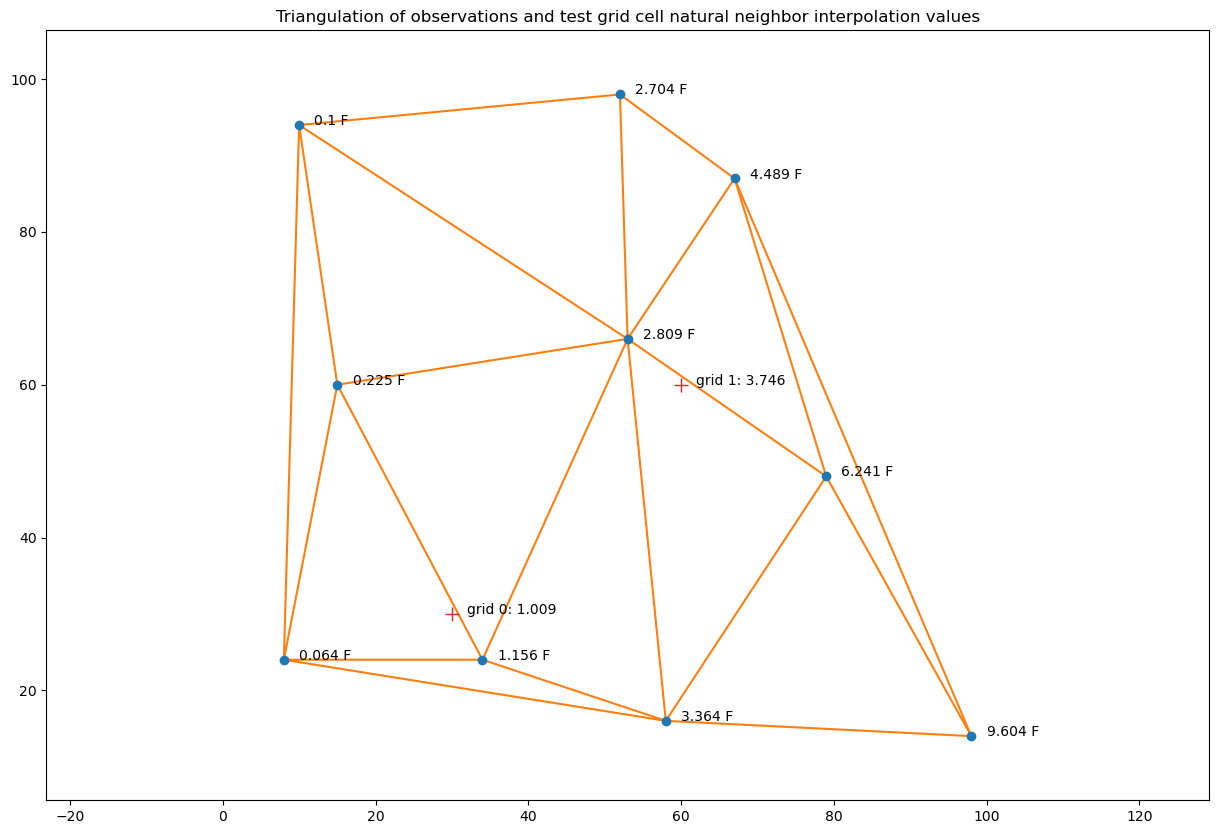

In [4]:
# Some randomly selected points
pts = np.array([[8, 24], [67, 87], [79, 48], [10, 94], [52, 98],
                [53, 66], [98, 14], [34, 24], [15, 60], [58, 16]])

xp = pts[:, 0]
yp = pts[:, 1]
zp = (pts[:, 0] * pts[:, 0]) / 1000

tri = Delaunay(pts)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.ishold = lambda: True  # Work-around for Matplotlib 3.0.0 incompatibility
delaunay_plot_2d(tri, ax=ax)

for i, zval in enumerate(zp):
    ax.annotate(f'{zval} F', xy=(pts[i, 0] + 2, pts[i, 1]))

sim_gridx = [30., 60.]
sim_gridy = [30., 60.]

ax.plot(sim_gridx, sim_gridy, '+', markersize=10)
ax.set_aspect('equal', 'datalim')
ax.set_title('Triangulation of observations and test grid cell '
             'natural neighbor interpolation values')

members, circumcenters = geometry.find_natural_neighbors(tri, list(zip(sim_gridx, sim_gridy,
                                                                       strict=False)))

val = natural_neighbor_point(xp, yp, zp, (sim_gridx[0], sim_gridy[0]), tri, members[0],
                             circumcenters)
ax.annotate(f'grid 0: {val:.3f}', xy=(sim_gridx[0] + 2, sim_gridy[0]))

val = natural_neighbor_point(xp, yp, zp, (sim_gridx[1], sim_gridy[1]), tri, members[1],
                             circumcenters)
ax.annotate(f'grid 1: {val:.3f}', xy=(sim_gridx[1] + 2, sim_gridy[1]))


Using the circumcenter and circumcircle radius information from
`metpy.interpolate.find_natural_neighbors`, we can visually
examine the results to see if they are correct.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


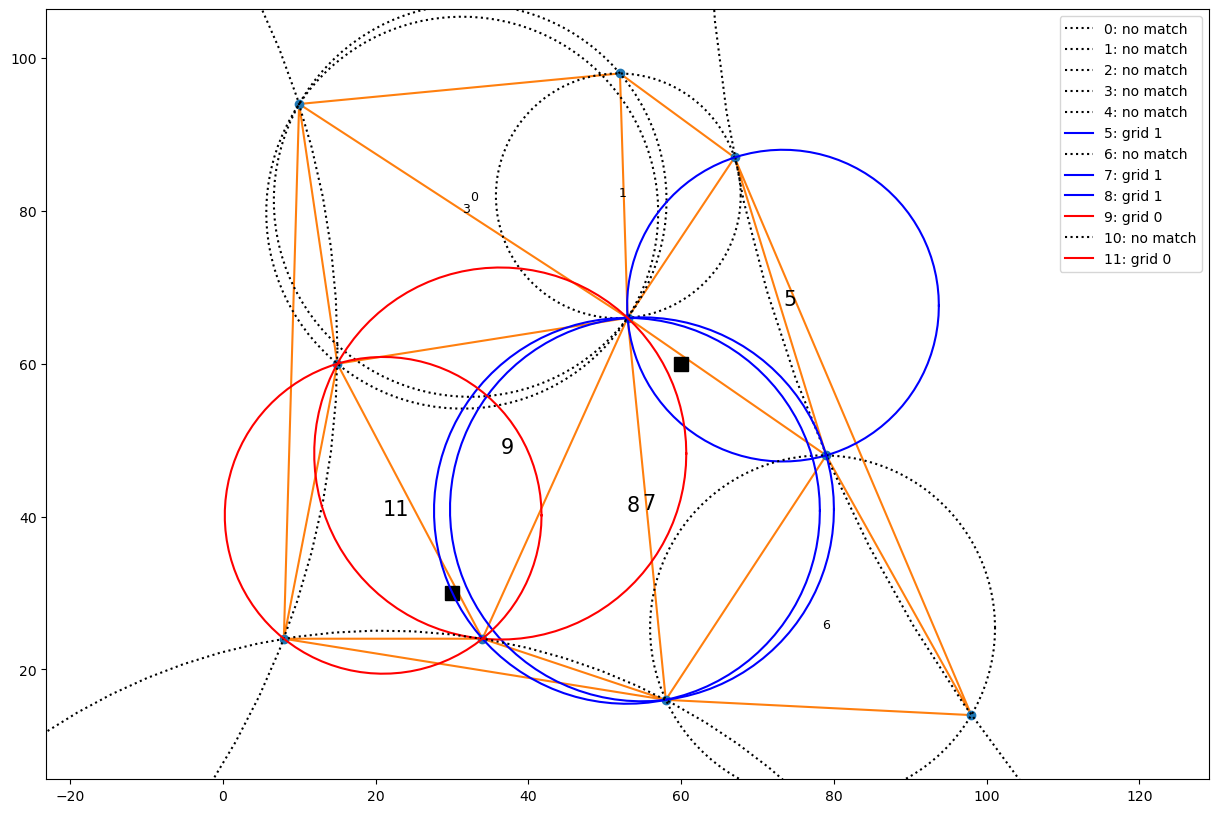

In [5]:
def draw_circle(ax, x, y, r, m, label):
    th = np.linspace(0, 2 * np.pi, 100)
    nx = x + r * np.cos(th)
    ny = y + r * np.sin(th)
    ax.plot(nx, ny, m, label=label)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.ishold = lambda: True  # Work-around for Matplotlib 3.0.0 incompatibility
delaunay_plot_2d(tri, ax=ax)
ax.plot(sim_gridx, sim_gridy, 'ks', markersize=10)

for i, (x_t, y_t) in enumerate(circumcenters):
    r = geometry.circumcircle_radius(*tri.points[tri.simplices[i]])
    if i in members[1] and i in members[0]:
        draw_circle(ax, x_t, y_t, r, 'm-', str(i) + ': grid 1 & 2')
        ax.annotate(str(i), xy=(x_t, y_t), fontsize=15)
    elif i in members[0]:
        draw_circle(ax, x_t, y_t, r, 'r-', str(i) + ': grid 0')
        ax.annotate(str(i), xy=(x_t, y_t), fontsize=15)
    elif i in members[1]:
        draw_circle(ax, x_t, y_t, r, 'b-', str(i) + ': grid 1')
        ax.annotate(str(i), xy=(x_t, y_t), fontsize=15)
    else:
        draw_circle(ax, x_t, y_t, r, 'k:', str(i) + ': no match')
        ax.annotate(str(i), xy=(x_t, y_t), fontsize=9)

ax.set_aspect('equal', 'datalim')
ax.legend()

What?....the circle from triangle 8 looks pretty darn close. Why isn't
grid 0 included in that circle?

In [6]:
x_t, y_t = circumcenters[8]
r = geometry.circumcircle_radius(*tri.points[tri.simplices[8]])

print('Distance between grid0 and Triangle 8 circumcenter:',
      euclidean([x_t, y_t], [sim_gridx[0], sim_gridy[0]]))
print('Triangle 8 circumradius:', r)

Distance between grid0 and Triangle 8 circumcenter: 25.30650398368644
Triangle 8 circumradius: 25.258767799971746


Lets do a manual check of the above interpolation value for grid 0 (southernmost grid)
Grab the circumcenters and radii for natural neighbors

In [7]:
cc = np.array([circumcenters[m] for m in members[0]])
r = np.array([geometry.circumcircle_radius(*tri.points[tri.simplices[m]]) for m in members[0]])

print('circumcenters:\n', cc)
print('radii\n', r)

circumcenters:
 [[36.32995951 48.24358974]
 [21.         40.15277778]]
radii
 [24.35529419 20.73432492]


Draw the natural neighbor triangles and their circumcenters. Also plot a [Voronoi diagram](https://docs.scipy.org/doc/scipy/tutorial/spatial.html#voronoi-diagrams)
which serves as a complementary (but not necessary)
spatial data structure that we use here simply to show areal ratios.
Notice that the two natural neighbor triangle circumcenters are also vertices
in the Voronoi plot (green dots), and the observations are in the polygons (blue dots).

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


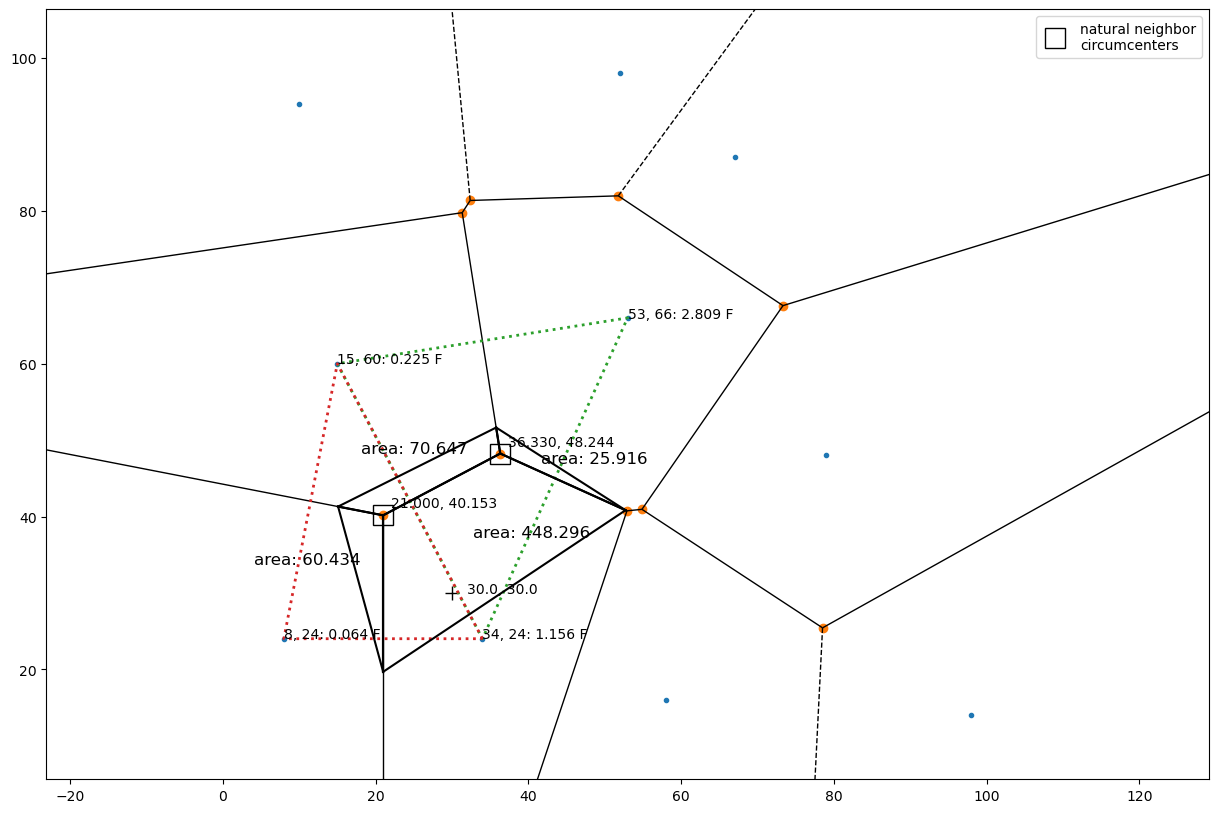

In [8]:
vort = Voronoi(list(zip(xp, yp, strict=False)))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.ishold = lambda: True  # Work-around for Matplotlib 3.0.0 incompatibility
voronoi_plot_2d(vort, ax=ax)

nn_ind = np.array([0, 5, 7, 8])
z_0 = zp[nn_ind]
x_0 = xp[nn_ind]
y_0 = yp[nn_ind]

for x, y, z in zip(x_0, y_0, z_0, strict=False):
    ax.annotate(f'{x}, {y}: {z:.3f} F', xy=(x, y))

ax.plot(sim_gridx[0], sim_gridy[0], 'k+', markersize=10)
ax.annotate(f'{sim_gridx[0]}, {sim_gridy[0]}', xy=(sim_gridx[0] + 2, sim_gridy[0]))
ax.plot(cc[:, 0], cc[:, 1], 'ks', markersize=15, fillstyle='none',
        label='natural neighbor\ncircumcenters')

for center in cc:
    ax.annotate(f'{center[0]:.3f}, {center[1]:.3f}', xy=(center[0] + 1, center[1] + 1))

tris = tri.points[tri.simplices[members[0]]]
for triangle in tris:
    x = [triangle[0, 0], triangle[1, 0], triangle[2, 0], triangle[0, 0]]
    y = [triangle[0, 1], triangle[1, 1], triangle[2, 1], triangle[0, 1]]
    ax.plot(x, y, ':', linewidth=2)

ax.legend()
ax.set_aspect('equal', 'datalim')


def draw_polygon_with_info(ax, polygon, off_x=0, off_y=0):
    """Draw one of the natural neighbor polygons with some information."""
    pts = np.array(polygon)[ConvexHull(polygon).vertices]
    for i, pt in enumerate(pts):
        ax.plot([pt[0], pts[(i + 1) % len(pts)][0]],
                [pt[1], pts[(i + 1) % len(pts)][1]], 'k-')

    avex, avey = np.mean(pts, axis=0)
    ax.annotate(f'area: {geometry.area(pts):.3f}', xy=(avex + off_x, avey + off_y),
                fontsize=12)


cc1 = geometry.circumcenter((53, 66), (15, 60), (30, 30))
cc2 = geometry.circumcenter((34, 24), (53, 66), (30, 30))
draw_polygon_with_info(ax, [cc[0], cc1, cc2])

cc1 = geometry.circumcenter((53, 66), (15, 60), (30, 30))
cc2 = geometry.circumcenter((15, 60), (8, 24), (30, 30))
draw_polygon_with_info(ax, [cc[0], cc[1], cc1, cc2], off_x=-9, off_y=3)

cc1 = geometry.circumcenter((8, 24), (34, 24), (30, 30))
cc2 = geometry.circumcenter((15, 60), (8, 24), (30, 30))
draw_polygon_with_info(ax, [cc[1], cc1, cc2], off_x=-15)

cc1 = geometry.circumcenter((8, 24), (34, 24), (30, 30))
cc2 = geometry.circumcenter((34, 24), (53, 66), (30, 30))
draw_polygon_with_info(ax, [cc[0], cc[1], cc1, cc2])

Put all of the generated polygon areas and their affiliated values in arrays.
Calculate the total area of all of the generated polygons.

In [9]:
areas = np.array([60.434, 448.296, 25.916, 70.647])
values = np.array([0.064, 1.156, 2.809, 0.225])
total_area = np.sum(areas)
print(total_area)

605.2930000000001


For each polygon area, calculate its percent of total area.

In [10]:
proportions = areas / total_area
print(proportions)

[0.09984256 0.74062644 0.04281563 0.11671538]


Multiply the percent of total area by the respective values.

In [11]:
contributions = proportions * values
print(contributions)

[0.00638992 0.85616417 0.1202691  0.02626096]


The sum of this array is the interpolation value!

In [12]:
interpolation_value = np.sum(contributions)
function_output = natural_neighbor_point(xp, yp, zp, (sim_gridx[0], sim_gridy[0]), tri,
                                         members[0], circumcenters)

print(interpolation_value, function_output)

1.0090841476772403 1.009084244425604


The values are slightly different due to truncating the area values in
the above visual example to the 3rd decimal place.

In [13]:
plt.show()